# Credit Card Lead Prediction

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score,precision_score 
from sklearn.metrics import classification_report,cohen_kappa_score ,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier,\
StackingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = [15,10]

## Data understanding

In [3]:
#load the train dataset
df_train = pd.read_csv('train_s3TEQDk.csv')
df_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
#load the test dataset
df_test = pd.read_csv('test_mSzZ8RL.csv')
df_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [5]:
#rows and columns of train and test dataset
df_train.shape,df_test.shape

((245725, 11), (105312, 10))

In [6]:
#datatypes in train set
df_train.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [7]:
#datatypes in test set
df_test.dtypes

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
dtype: object

In [8]:
#check the null values in train set
df_train.isnull().sum()/len(df_train)*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64

In [9]:
#check the null values in test set
df_test.isnull().sum()/len(df_test)*100

ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64

### There are null values in the variable "credit_product" in both train and test data

In [10]:
#extracting the categorical columns name for train data
cat_col = df_train.select_dtypes(include='object').columns
cat_col

Index(['ID', 'Gender', 'Region_Code', 'Occupation', 'Channel_Code',
       'Credit_Product', 'Is_Active'],
      dtype='object')

In [11]:
#counts in each category in train
for i in cat_col:
    print('\n',df_train[i].value_counts(),'\n')
    print('*'*85)


 IJQVGH4G    1
SJFDRLGW    1
UQX8CZUY    1
MRXDVPTS    1
NVYF2ZPU    1
           ..
ZQ4HPAAU    1
F2GB5CFF    1
9E6L7CFD    1
CV8VDFBW    1
LGTD2BMS    1
Name: ID, Length: 245725, dtype: int64 

*************************************************************************************

 Male      134197
Female    111528
Name: Gender, dtype: int64 

*************************************************************************************

 RG268    35934
RG283    29416
RG254    26840
RG284    19320
RG277    12826
RG280    12775
RG269     7863
RG270     7720
RG261     7633
RG257     6101
RG251     5950
RG282     5829
RG274     5286
RG272     5252
RG281     5093
RG273     4497
RG252     4286
RG279     3976
RG263     3687
RG275     3245
RG260     3110
RG256     2847
RG264     2793
RG276     2764
RG259     2586
RG250     2496
RG255     2018
RG258     1951
RG253     1858
RG278     1822
RG262     1788
RG266     1578
RG265     1546
RG271     1542
RG267     1497
Name: Region_Code, dtype: int64 

*****

In [12]:
#extracting the categorical columns name for test data
cat_col_test = df_test.select_dtypes(include='object').columns
cat_col_test

Index(['ID', 'Gender', 'Region_Code', 'Occupation', 'Channel_Code',
       'Credit_Product', 'Is_Active'],
      dtype='object')

In [13]:
#counts in each category in test
for i in cat_col:
    print('\n',df_test[i].value_counts(),'\n')
    print('*'*85)


 CODNJVV2    1
NANZCMCE    1
RWUQGUXO    1
UUQSXK5T    1
2AADFPXK    1
           ..
PJNMQZME    1
NPBSPKFX    1
8NZXFHTU    1
BQUCWFL7    1
I45PNTSC    1
Name: ID, Length: 105312, dtype: int64 

*************************************************************************************

 Male      57705
Female    47607
Name: Gender, dtype: int64 

*************************************************************************************

 RG268    15125
RG283    12881
RG254    11737
RG284     8173
RG277     5596
RG280     5529
RG270     3440
RG269     3288
RG261     3286
RG251     2678
RG257     2588
RG272     2338
RG282     2337
RG274     2208
RG281     2144
RG252     1811
RG273     1803
RG263     1615
RG279     1600
RG275     1383
RG260     1300
RG264     1241
RG256     1194
RG276     1185
RG259     1102
RG250     1048
RG255      891
RG278      824
RG258      812
RG253      810
RG262      800
RG265      668
RG271      654
RG266      631
RG267      592
Name: Region_Code, dtype: int64 

*******

#### missing value imputation

In [14]:
#fill the missing value in train
df_train['Credit_Product']=df_train['Credit_Product'].fillna(df_train['Credit_Product'].mode()[0])

In [15]:
#fill the missing value in test
df_test['Credit_Product']=df_test['Credit_Product'].fillna(df_test['Credit_Product'].mode()[0])

In [16]:
#check the null values after imputation
df_train.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
Is_Lead                0
dtype: int64

In [17]:
#check the null values after imputation
df_test.isnull().sum()

ID                     0
Gender                 0
Age                    0
Region_Code            0
Occupation             0
Channel_Code           0
Vintage                0
Credit_Product         0
Avg_Account_Balance    0
Is_Active              0
dtype: int64

In [18]:
#summary statistics in train
df_train.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [19]:
#summary statistics in test
df_test.describe()

,Age,Vintage,Avg_Account_Balance
count,105312.000000,105312.000000,1.053120e+05
mean,43.871002,46.842819,1.134195e+06
std,14.872890,32.273634,8.662430e+05
min,24.000000,7.000000,2.259700e+04
25%,30.000000,20.000000,6.039822e+05
50%,43.000000,32.000000,8.966345e+05
75%,54.000000,73.000000,1.371598e+06
max,85.000000,135.000000,9.908858e+06


In [20]:
# checking number of unique values in each columns
for col in df_train.columns:
    print(col,':',df_train[col].nunique())

ID : 245725
Gender : 2
Age : 63
Region_Code : 35
Occupation : 4
Channel_Code : 4
Vintage : 66
Credit_Product : 2
Avg_Account_Balance : 135292
Is_Active : 2
Is_Lead : 2


In [21]:
# checking number of unique values in each columns
for col in df_test.columns:
    print(col,':',df_test[col].nunique())

ID : 105312
Gender : 2
Age : 62
Region_Code : 35
Occupation : 4
Channel_Code : 4
Vintage : 66
Credit_Product : 2
Avg_Account_Balance : 78315
Is_Active : 2


In [22]:
# skewness & kurtosis in train
pd.DataFrame({"Skewness": df_train[['Age','Vintage','Avg_Account_Balance']].skew(), "Kurtosis": df_train[['Age','Vintage','Avg_Account_Balance']].kurt()})

,Skewness,Kurtosis
Age,0.618992,-0.441273
Vintage,0.790189,-0.696540
Avg_Account_Balance,2.968727,14.304594


In [23]:
# skewness & kurtosis in test
pd.DataFrame({"Skewness": df_test.skew(), "Kurtosis": df_test.kurt()})

,Skewness,Kurtosis
Age,0.628495,-0.423121
Vintage,0.791252,-0.689137
Avg_Account_Balance,2.998225,14.430061


##### There is skewness and kurtosis in the feature 'Avg_Account_Balance'

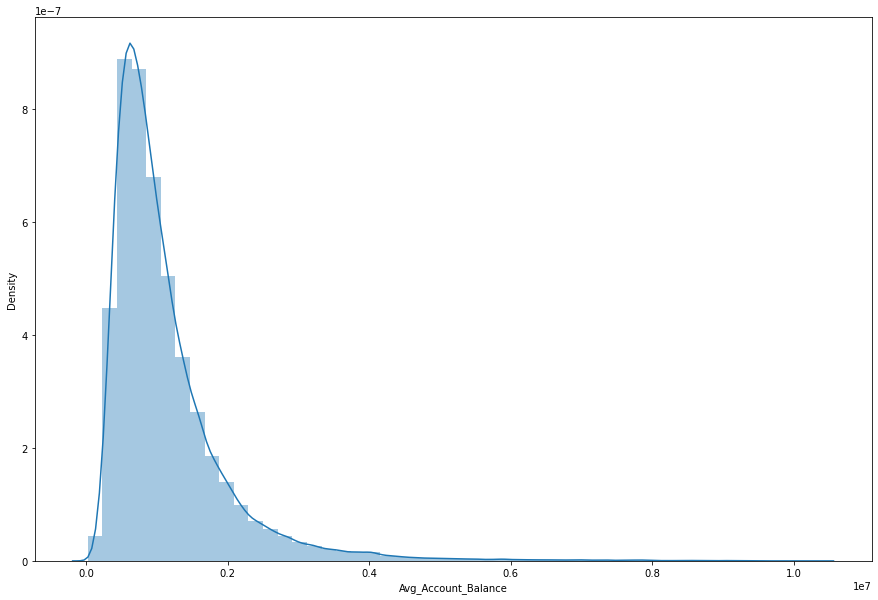

In [24]:
#check distribution for 'Avg_Account_Balance' using distplot in train data
sns.distplot(df_train['Avg_Account_Balance'])
plt.show()

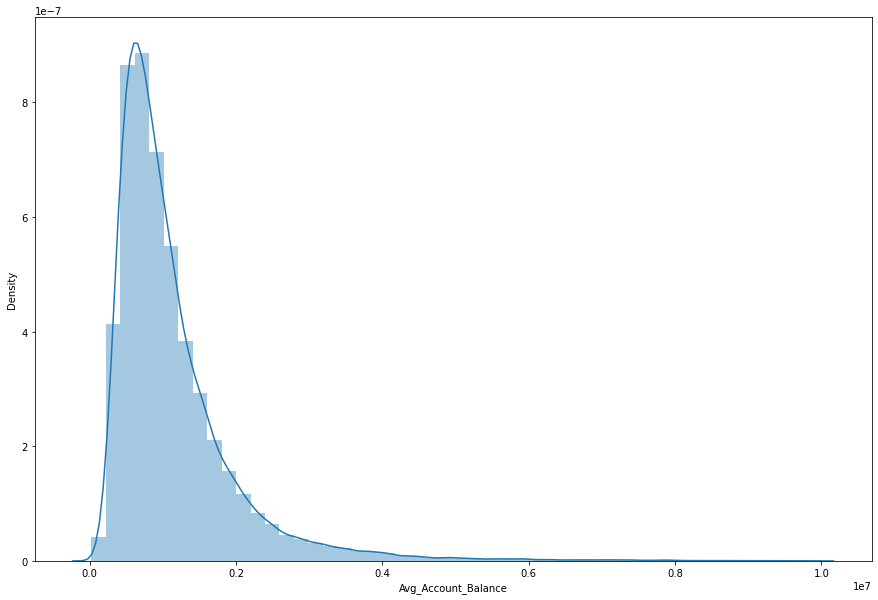

In [25]:
#check distribution for 'Avg_Account_Balance' using distplot in test data
sns.distplot(df_test['Avg_Account_Balance'])
plt.show()

##### To reduce the skewness , log transformation is used .

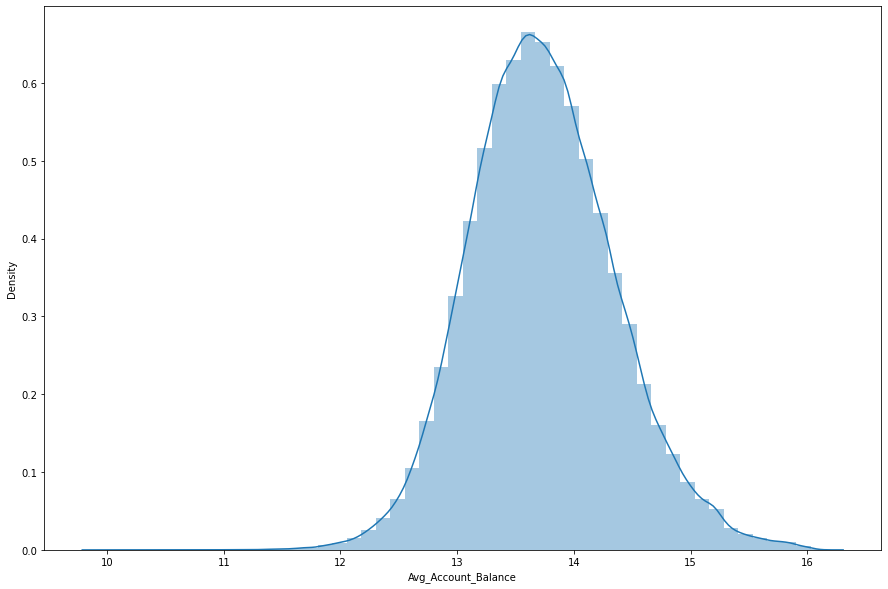

In [26]:
#apply log transformation to reduce the skewness
df_train['Avg_Account_Balance'] =np.log(df_train['Avg_Account_Balance'])
sns.distplot(df_train['Avg_Account_Balance'])
plt.show()

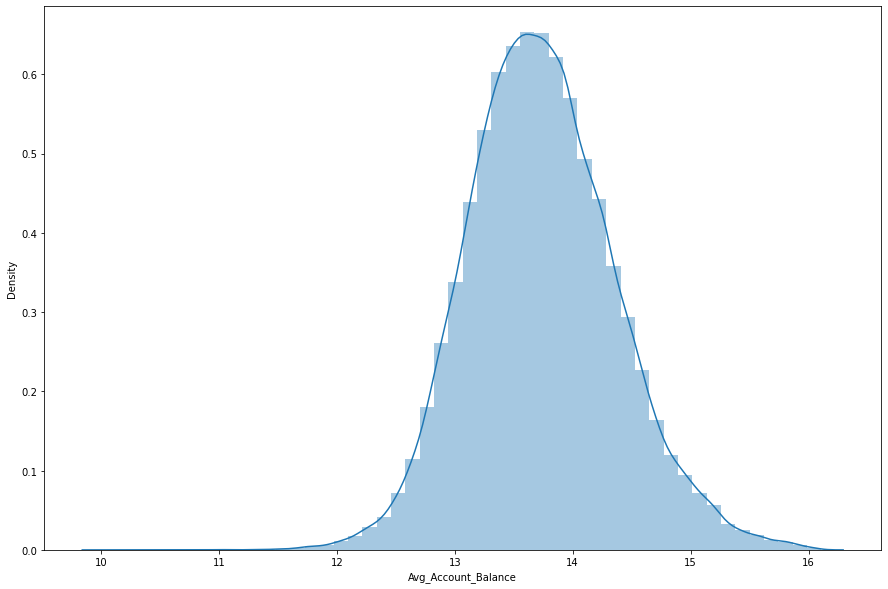

In [27]:
#apply log transformation to reduce the skewness
df_test['Avg_Account_Balance'] =np.log(df_test['Avg_Account_Balance'])
sns.distplot(df_test['Avg_Account_Balance'])
plt.show()

In [28]:
# skewness & kurtosis after transformation in train 
pd.DataFrame({"Skewness": df_train[['Age','Vintage','Avg_Account_Balance']].skew(), "Kurtosis": df_train[['Age','Vintage','Avg_Account_Balance']].kurt()})

,Skewness,Kurtosis
Age,0.618992,-0.441273
Vintage,0.790189,-0.696540
Avg_Account_Balance,0.235178,0.306033


In [29]:
# skewness & kurtosis after transformation in test
pd.DataFrame({"Skewness": df_test.skew(), "Kurtosis": df_test.kurt()})

,Skewness,Kurtosis
Age,0.628495,-0.423121
Vintage,0.791252,-0.689137
Avg_Account_Balance,0.251806,0.315495


##### skewness and kurtosis is reduced for  'Avg_Account_Balance'

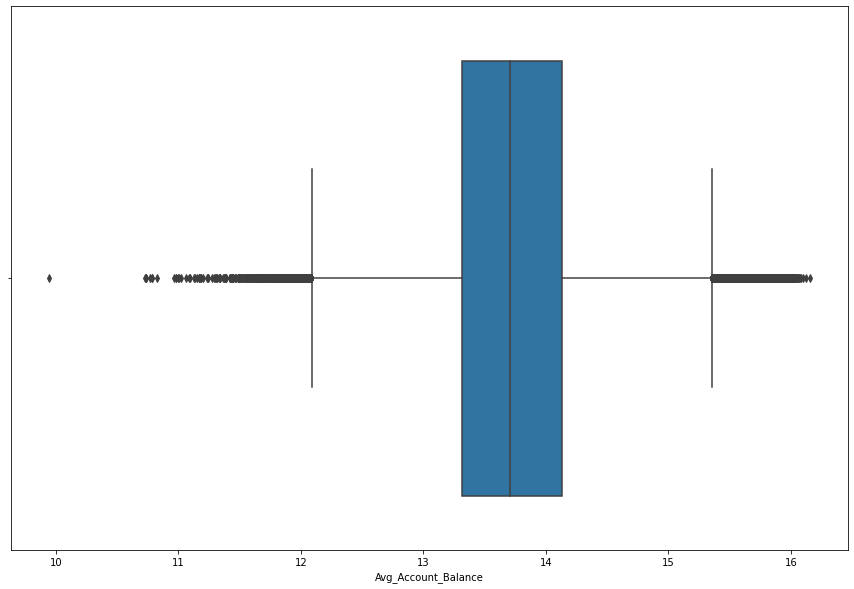

In [30]:
sns.boxplot(df_train['Avg_Account_Balance'])
plt.show()

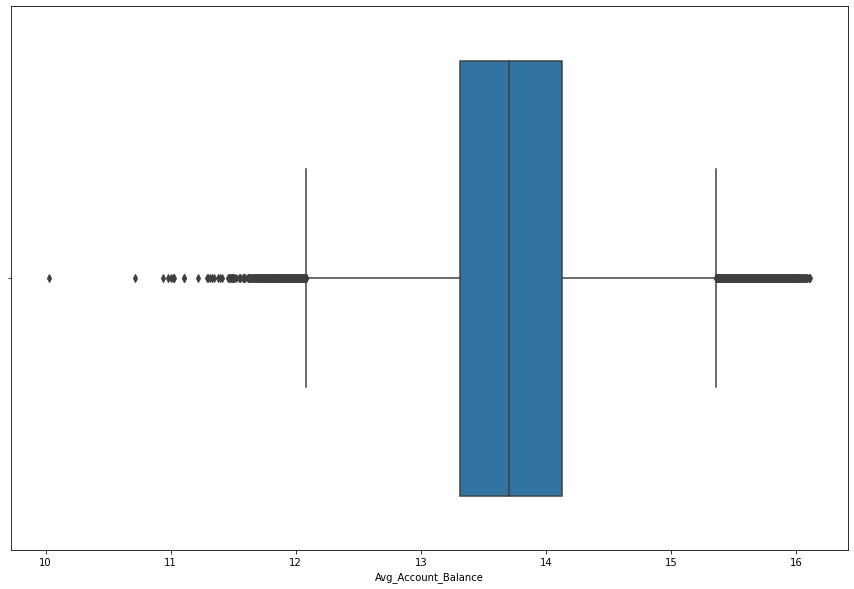

In [31]:
sns.boxplot(df_test['Avg_Account_Balance'])
plt.show()

In [32]:
#correlation for train
df_train[['Age','Vintage','Avg_Account_Balance']].corr()

,Age,Vintage,Avg_Account_Balance
Age,1.000000,0.631242,0.176838
Vintage,0.631242,1.000000,0.201592
Avg_Account_Balance,0.176838,0.201592,1.000000


In [33]:
#correlation for test
df_test.corr()

,Age,Vintage,Avg_Account_Balance
Age,1.000000,0.622310,0.169169
Vintage,0.622310,1.000000,0.200641
Avg_Account_Balance,0.169169,0.200641,1.000000


##### univariate, Bivariate,Multi variate analysis

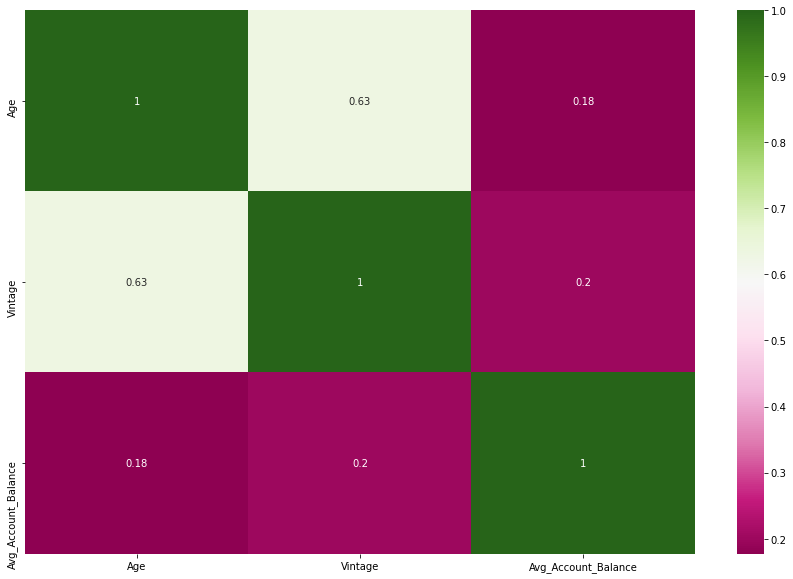

In [34]:
sns.heatmap(df_train[['Age','Vintage','Avg_Account_Balance']].corr(),annot=True,cmap='PiYG')
plt.show()

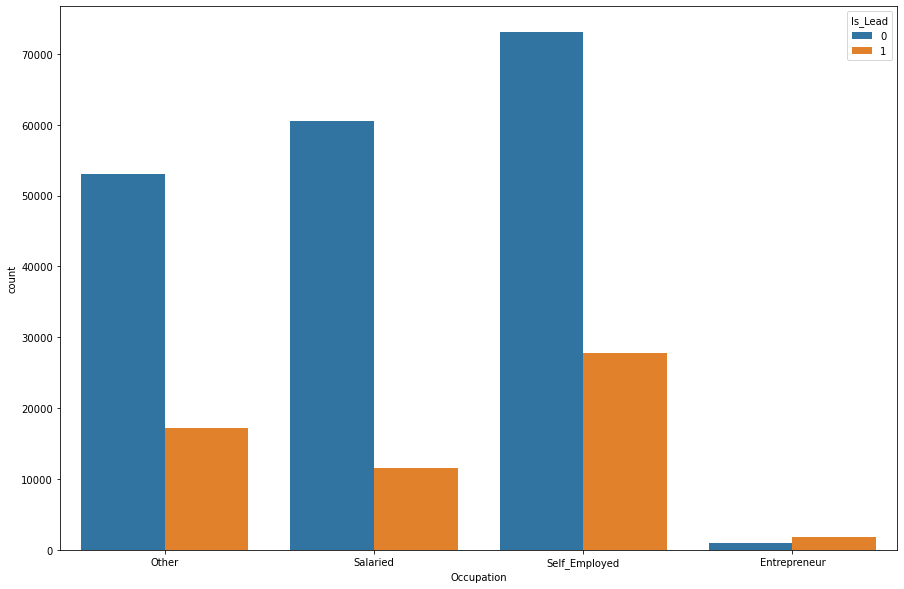

In [35]:
sns.countplot(df_train['Occupation'],hue=df_train['Is_Lead'])
plt.show()

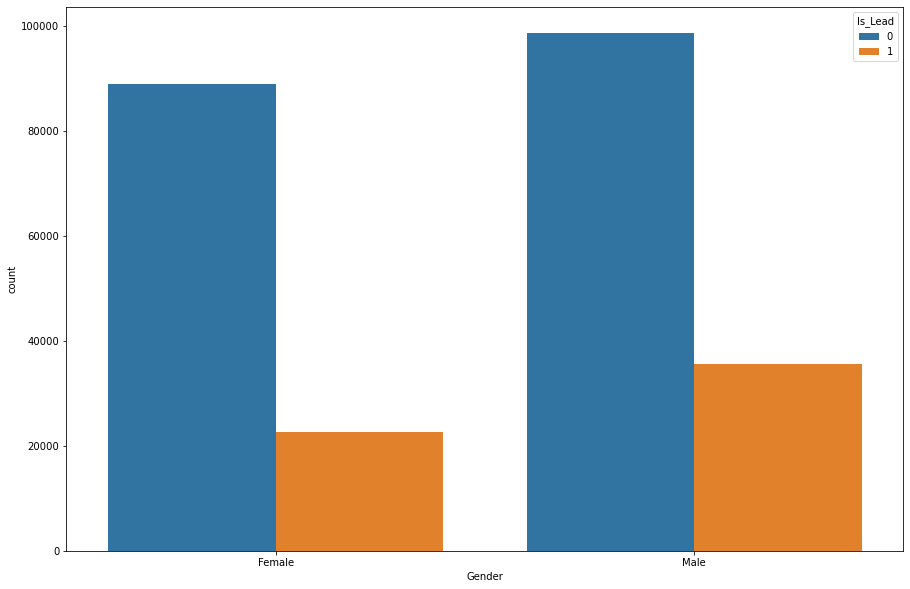

In [36]:
sns.countplot(df_train['Gender'],hue=df_train['Is_Lead'])
plt.show()

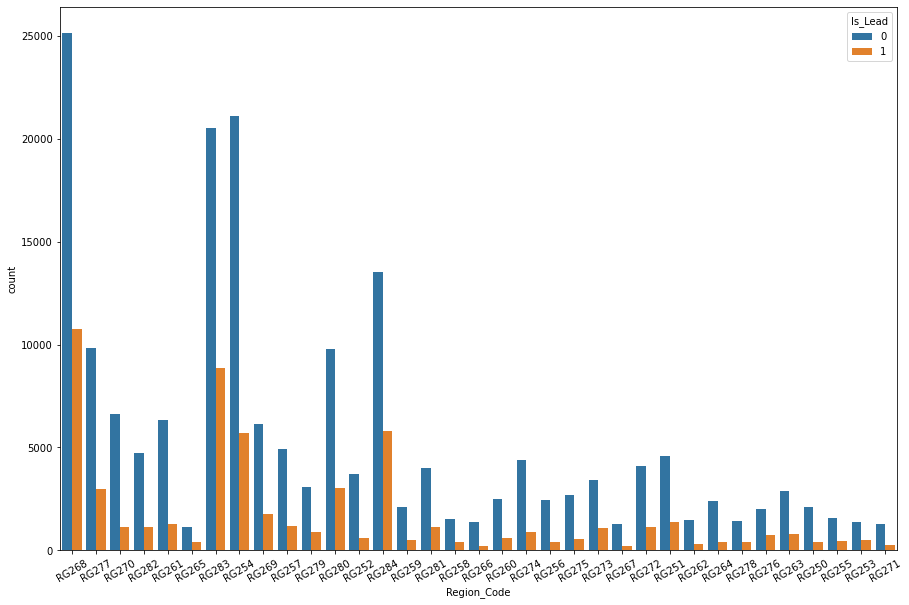

In [37]:
sns.countplot(df_train['Region_Code'],hue=df_train['Is_Lead'])
plt.xticks(rotation=30)
plt.show()

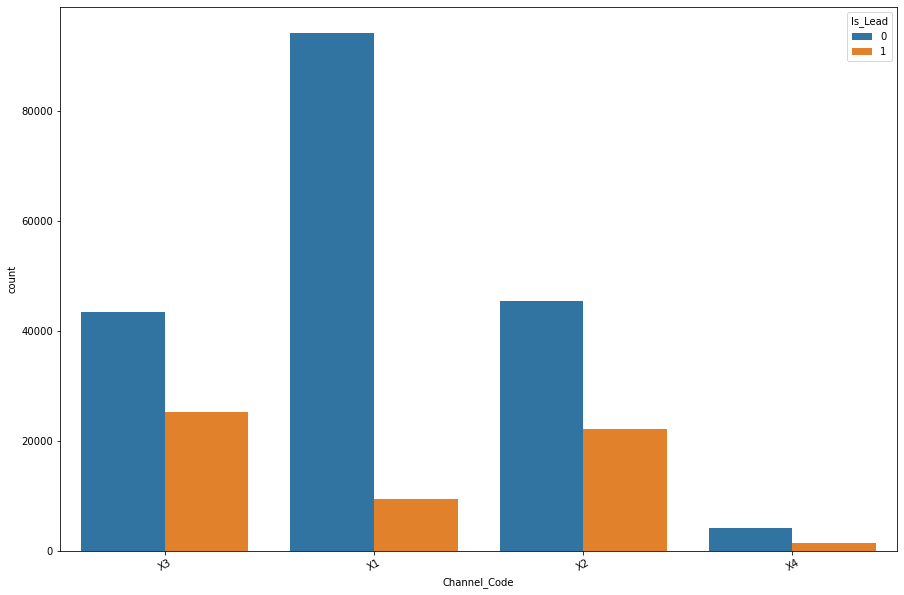

In [38]:
sns.countplot(df_train['Channel_Code'],hue=df_train['Is_Lead'])
plt.xticks(rotation=30)
plt.show()

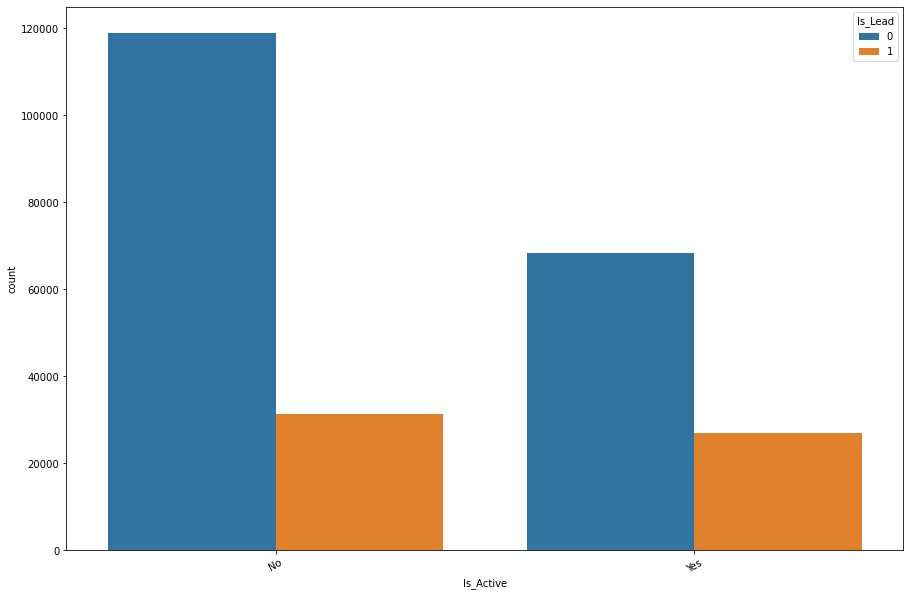

In [39]:
sns.countplot(df_train['Is_Active'],hue=df_train['Is_Lead'])
plt.xticks(rotation=30)
plt.show()

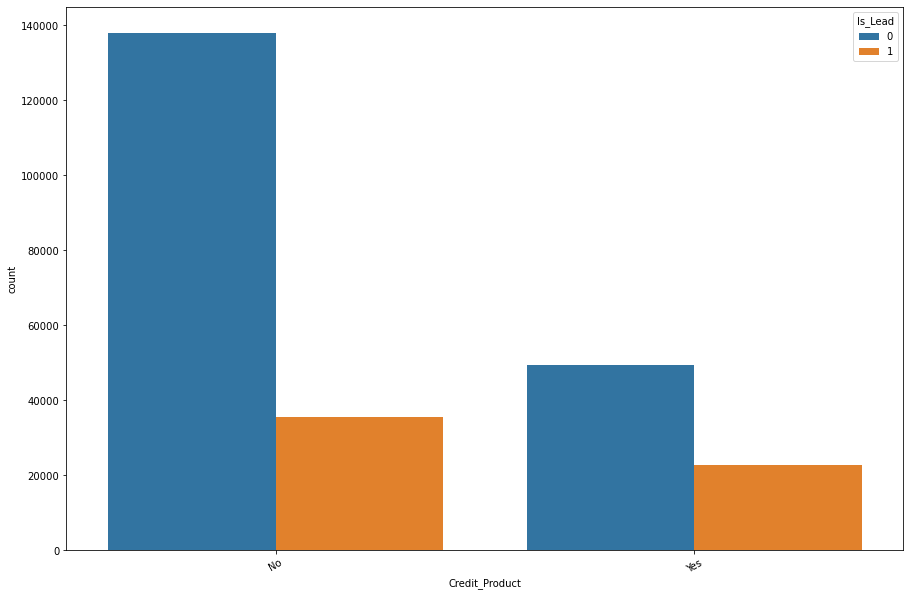

In [40]:
sns.countplot(df_train['Credit_Product'],hue=df_train['Is_Lead'])
plt.xticks(rotation=30)
plt.show()

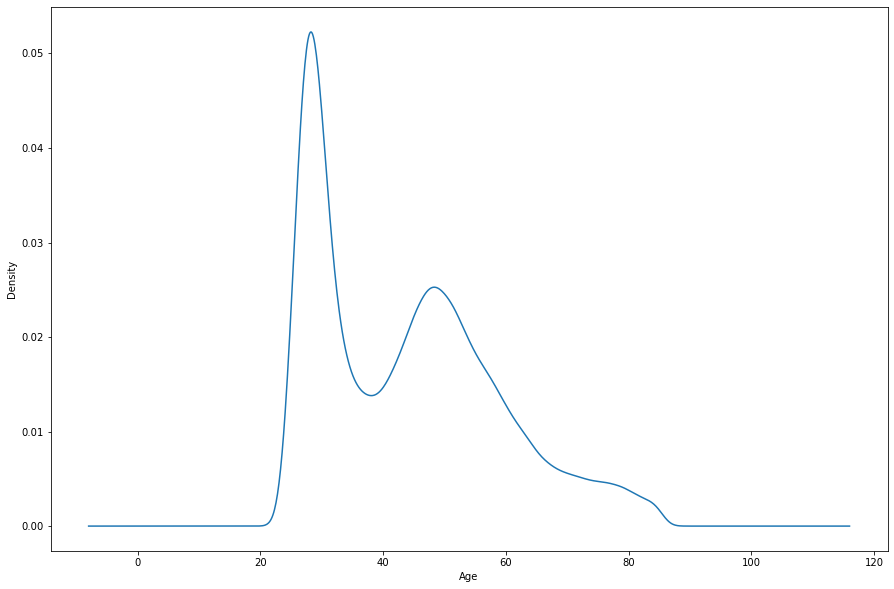

In [41]:
df_train['Age'].plot(kind='kde')
plt.xlabel('Age')
plt.show()

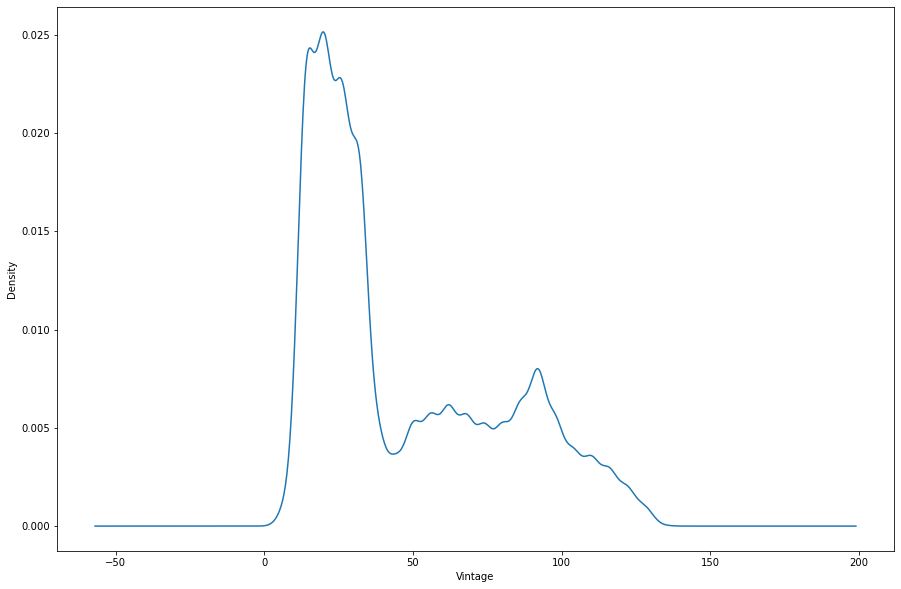

In [42]:
df_train['Vintage'].plot(kind='kde')
plt.xlabel('Vintage')
plt.show()

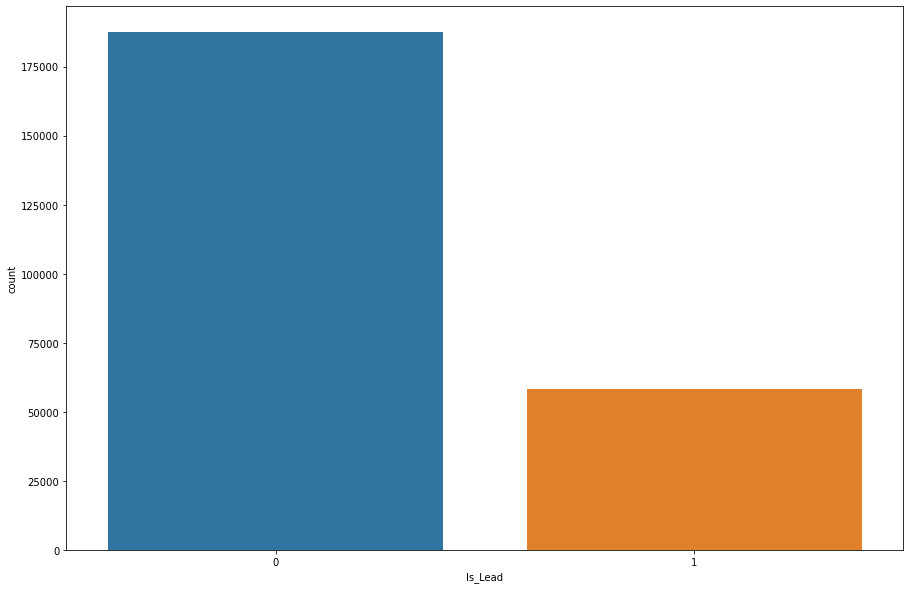

In [43]:
sns.countplot(df_train['Is_Lead'])
plt.show()

# encoding for categorical variables

In [44]:
#Label encoding for categorical variables in train data
le = LabelEncoder()
cat_col = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
for i in cat_col:
    df_train[i] =le.fit_transform(df_train[i])

In [45]:
#Label encoding for categorical variables in test data
le = LabelEncoder()
cat_col = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
for i in cat_col:
    df_test[i]=le.fit_transform(df_test[i])

In [46]:
#train data after encoding
df_train.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,0,73,18,1,2,43,0,13.860193,0,0
1,IDD62UNG,0,30,27,2,0,32,0,13.274205,0,0
2,HD3DSEMC,0,56,18,3,2,26,0,14.210464,1,0


In [47]:
#test data after encoding
df_test.head(3)

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,1,29,4,1,0,25,1,13.517598,0
1,CCMEWNKY,1,43,18,1,1,49,0,13.738129,0
2,VK3KGA9M,1,31,20,2,0,14,0,12.282798,0


In [48]:
#percentage of class in 'Is_lead' (target variable)
df_train['Is_Lead'].value_counts()/len(df_train)*100

0    76.279174
1    23.720826
Name: Is_Lead, dtype: float64

# Model building

#### Base model

In [49]:
train =df_train.copy()
test = df_test.copy()

In [50]:
#split into x and y
X = train.drop(['ID','Is_Lead'],axis=1)
y = train['Is_Lead']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1000, test_size = 0.3)

In [52]:
score_card = pd.DataFrame(columns=['Model','Precision Score','Recall Score','Accuracy Score','f1-score','AUC Score'])

def scores(model_name,y_test,y_pred):
    precision = (round(precision_score(y_test,y_pred),4))
    recall    = (round(recall_score(y_test,y_pred),4))
    accuracy  = (round(accuracy_score(y_test,y_pred),4) ) 
    f1        = (round(f1_score(y_test,y_pred),4))
    auc       = (round(roc_auc_score(y_test, y_pred),4))
    global score_card
    score_card = score_card.append({'Model' : model_name,                              
                                    'Precision Score': precision,
                                    'Recall Score': recall,
                                    'Accuracy Score': accuracy,
                                    'f1-score': f1,
                                    'AUC Score' : auc
                                    },ignore_index = True)
    return score_card.sort_values(by='Accuracy Score',ascending= False).reset_index(drop=True)
    
# Logistic Regression
def log_reg(X_train,X_test, y_train,y_test):
    lr = LogisticRegression()
    lr = lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    name = 'Logistic Regression'
    log_score = scores(name,y_test,pred)
    train_pred = lr.predict(X_train)
    return log_score

# Decision Tree Classifier
def dtree(X_train,X_test, y_train,y_test):
    decision_tree = DecisionTreeClassifier()
    dt_model = decision_tree.fit(X_train,y_train)
    pred = dt_model.predict(X_test)
    name = 'Decision Tree'
    dt_score = scores(name,y_test,pred)
    return dt_score

#Random Forest Classifier
def random(X_train,X_test, y_train,y_test):
    rf = RandomForestClassifier()
    rf_model = rf.fit(X_train,y_train)
    pred = rf_model.predict(X_test)
    name = 'Random Forest'
    rf_score = scores(name,y_test,pred)
    return rf_score

#Ada Boost Classifier
def ada(X_train,X_test, y_train,y_test):
    ad = AdaBoostClassifier()
    ad_model = ad.fit(X_train,y_train)
    pred = ad_model.predict(X_test)
    name = 'Ada Boost'
    ad_score = scores(name,y_test,pred)
    return ad_score

#Gradient Boosting Classifier
def gboost(X_train,X_test, y_train,y_test):
    gb = GradientBoostingClassifier()
    gb_model = gb.fit(X_train,y_train)
    pred = gb_model.predict(X_test)
    name = 'Gradient Boosting'
    gb_score = scores(name,y_test,pred)
    return gb_score

#Bagging Classifier
def bag(X_train,X_test, y_train,y_test):
    bg = BaggingClassifier()
    bg_model = bg.fit(X_train,y_train)
    pred = bg_model.predict(X_test)
    name = 'Bagging Classifier'
    bg_score = scores(name,y_test,pred)
    return bg_score

#Extreme Gradient Boost Classifier
def xgb(X_train,X_test, y_train,y_test):
    xg = XGBClassifier()
    xg_model = xg.fit(X_train,y_train)
    pred = xg_model.predict(X_test)
    name = 'Extreme Gradient Boost Classifier'
    xg_score = scores(name,y_test,pred)
    return xg_score


In [53]:
log_reg(X_train, X_test, y_train, y_test)
dtree(X_train, X_test, y_train, y_test)
random(X_train, X_test, y_train, y_test)
ada(X_train, X_test, y_train, y_test)
gboost(X_train, X_test, y_train, y_test)
bag(X_train, X_test, y_train, y_test)
xgb(X_train, X_test, y_train, y_test)

[12:53:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Extreme Gradient Boost Classifier,0.6448,0.2773,0.7923,0.3878,0.6149
1,Gradient Boosting,0.6928,0.2169,0.7914,0.3304,0.5935
2,Ada Boost,0.6347,0.1950,0.7824,0.2984,0.5801
3,Random Forest,0.5624,0.3166,0.7795,0.4051,0.6200
4,Bagging Classifier,0.5207,0.2978,0.7684,0.3789,0.6063
5,Logistic Regression,0.4155,0.0965,0.7535,0.1566,0.5271
6,Decision Tree,0.3967,0.4205,0.7108,0.4082,0.6108


### The best performing base model based on Accuracy Score is Extreme Gradient Boost with a score of 0.7923 and corresponding AUC score is 0.6149

### SMOTE technique

In [54]:
#split into x and y
X = train.drop(['ID','Is_Lead'],axis=1)
y = train['Is_Lead']

In [55]:
#smote technique for class imbalance
s = SMOTE(random_state = 2)
X_smot, y_smot = s.fit_resample(X, y)

In [56]:
#shape of x and y 
X_smot.shape, y_smot.shape

((374874, 9), (374874,))

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_smot, y_smot, random_state = 1000, test_size = 0.3)

In [58]:
score_card = pd.DataFrame(columns=['Model','Precision Score','Recall Score','Accuracy Score','f1-score','AUC Score'])

def scores(model_name,y_test,y_pred):
    precision = (round(precision_score(y_test,y_pred),4))
    recall    = (round(recall_score(y_test,y_pred),4))
    accuracy  = (round(accuracy_score(y_test,y_pred),4) ) 
    f1        = (round(f1_score(y_test,y_pred),4))
    auc       = (round(roc_auc_score(y_test, y_pred),4))
    global score_card
    score_card = score_card.append({'Model' : model_name,                              
                                    'Precision Score': precision,
                                    'Recall Score': recall,
                                    'Accuracy Score': accuracy,
                                    'f1-score': f1,
                                    'AUC Score' : auc
                                    },ignore_index = True)
    return score_card.sort_values(by='Accuracy Score',ascending= False).reset_index(drop=True)
    
# Logistic Regression
def log_reg(X_train,X_test, y_train,y_test):
    lr = LogisticRegression()
    lr = lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    name = 'Logistic Regression'
    log_score = scores(name,y_test,pred)
    train_pred = lr.predict(X_train)
    return log_score

# Decision Tree Classifier
def dtree(X_train,X_test, y_train,y_test):
    decision_tree = DecisionTreeClassifier()
    dt_model = decision_tree.fit(X_train,y_train)
    pred = dt_model.predict(X_test)
    name = 'Decision Tree'
    dt_score = scores(name,y_test,pred)
    return dt_score

#Random Forest Classifier
def random(X_train,X_test, y_train,y_test):
    rf = RandomForestClassifier()
    rf_model = rf.fit(X_train,y_train)
    pred = rf_model.predict(X_test)
    name = 'Random Forest'
    rf_score = scores(name,y_test,pred)
    return rf_score

#Ada Boost Classifier
def ada(X_train,X_test, y_train,y_test):
    ad = AdaBoostClassifier()
    ad_model = ad.fit(X_train,y_train)
    pred = ad_model.predict(X_test)
    name = 'Ada Boost'
    ad_score = scores(name,y_test,pred)
    return ad_score

#Gradient Boosting Classifier
def gboost(X_train,X_test, y_train,y_test):
    gb = GradientBoostingClassifier()
    gb_model = gb.fit(X_train,y_train)
    pred = gb_model.predict(X_test)
    name = 'Gradient Boosting'
    gb_score = scores(name,y_test,pred)
    return gb_score

#Bagging Classifier
def bag(X_train,X_test, y_train,y_test):
    bg = BaggingClassifier()
    bg_model = bg.fit(X_train,y_train)
    pred = bg_model.predict(X_test)
    name = 'Bagging Classifier'
    bg_score = scores(name,y_test,pred)
    return bg_score

#Extreme Gradient Boost Classifier
def xgb(X_train,X_test, y_train,y_test):
    xg = XGBClassifier()
    xg_model = xg.fit(X_train,y_train)
    pred = xg_model.predict(X_test)
    name = 'Extreme Gradient Boost Classifier'
    xg_score = scores(name,y_test,pred)
    return xg_score

In [59]:
log_reg(X_train, X_test, y_train, y_test)
dtree(X_train, X_test, y_train, y_test)
random(X_train, X_test, y_train, y_test)
ada(X_train, X_test, y_train, y_test)
gboost(X_train, X_test, y_train, y_test)
bag(X_train, X_test, y_train, y_test)
xgb(X_train, X_test, y_train, y_test)

[12:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Random Forest,0.7726,0.8011,0.7833,0.7866,0.7834
1,Bagging Classifier,0.7662,0.7336,0.7556,0.7495,0.7555
2,Extreme Gradient Boost Classifier,0.7375,0.7345,0.7374,0.7360,0.7374
3,Gradient Boosting,0.7152,0.7439,0.7247,0.7293,0.7247
4,Decision Tree,0.7009,0.7341,0.7113,0.7171,0.7113
5,Ada Boost,0.6934,0.7357,0.7061,0.7140,0.7062
6,Logistic Regression,0.6585,0.6437,0.6560,0.6510,0.6559


### The best performing model using SMOTE based on Accuracy Score is Random Forest with a score of 0.7833 and corresponding AUC score is 0.7834

## Hyper parameter tuning

### XGB

In [60]:
params = {'learning_rate': [0.0001, 0.001, 0.01,0.1],
        'n_estimators':range(20,201,10),
        'max_depth':range(5,51,5),
        'min_samples_split':range(100,5001,500),
        'subsample':np.arange(0,1,0.1),
        'min_child_weight': range(0,20,5),
        'gamma': np.arange(0.0,5,0.5),
        'subsample': np.arange(0.0,1,0.2)
        }

In [61]:
xgb = XGBClassifier()

In [64]:
folds = 10
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[13:18:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:18:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'subsample': 0.4,
 'n_estimators': 30,
 'min_samples_split': 4600,
 'min_child_weight': 0,
 'max_depth': 45,
 'learning_rate': 0.0001,
 'gamma': 2.0}

### Random forest

In [65]:
tuned_parameters = [{'n_estimators':range(20,501,50),'max_features': ['auto', 'sqrt', 'log2'],'criterion':['gini','entropy']}]

folds = 10
param_comb = 5
rf_model = RandomForestClassifier()

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(rf_model , param_distributions=tuned_parameters, n_iter=param_comb, scoring='accuracy', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 10 folds for each of 5 candidates, totalling 50 fits


{'n_estimators': 370, 'max_features': 'log2', 'criterion': 'entropy'}

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_smot, y_smot, random_state = 1000, test_size = 0.3)

In [68]:
score_card = pd.DataFrame(columns=['Model','Precision Score','Recall Score','Accuracy Score','f1-score','AUC Score'])

def scores(model_name,y_test,y_pred):
    precision = (round(precision_score(y_test,y_pred),4))
    recall    = (round(recall_score(y_test,y_pred),4))
    accuracy  = (round(accuracy_score(y_test,y_pred),4) ) 
    f1        = (round(f1_score(y_test,y_pred),4))
    auc       = (round(roc_auc_score(y_test, y_pred),4))
    global score_card
    score_card = score_card.append({'Model' : model_name,                              
                                    'Precision Score': precision,
                                    'Recall Score': recall,
                                    'Accuracy Score': accuracy,
                                    'f1-score': f1,
                                    'AUC Score' : auc
                                    },ignore_index = True)
    return score_card.sort_values(by='Accuracy Score',ascending= False).reset_index(drop=True)


def xgb_fet_grid(X_train,X_test, y_train,y_test):
    xg = XGBClassifier(subsample=0.4, n_estimators= 30, min_samples_split= 4600, min_child_weight= 0,max_depth= 45, 
                       learning_rate= 0.0001, gamma = 2.0)
    xg_model = xg.fit(X_train,y_train)
    pred = xg_model.predict(X_test)
    name = 'Extreme Gradient Boost Classifier'
    xg_score = scores(name,y_test,pred)
    return xg_score


#Random Forest Classifier
def random_fet_grid(X_train,X_test, y_train,y_test):
    rf = RandomForestClassifier(n_estimators= 370, max_features='log2', criterion='entropy')
    rfe_rf = RFE(estimator = rf)
    rf_model = rfe_rf.fit(X_train,y_train)
    pred = rf_model.predict(X_test)
    name = 'Random Forest'
    rf_score = scores(name,y_test,pred)
    return rf_score

In [70]:
xgb_fet_grid(X_train,X_test, y_train,y_test)
random_fet_grid(X_train,X_test, y_train,y_test)

[14:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Model,Precision Score,Recall Score,Accuracy Score,f1-score,AUC Score
0,Extreme Gradient Boost Classifier,0.7506,0.7537,0.7524,0.7522,0.7524
1,Random Forest,0.6975,0.7432,0.7113,0.7196,0.7114


#### Extreme Gradient boost gives the accuracy of 0.7524 .

In [78]:
def get_train_report(model,X_train,y_train):
    train_pred = model.fit(X_train,y_train).predict(X_train)
    return f'\nTrain report : \n {classification_report(y_train, train_pred)}'

def get_test_report(model,X_test,y_test):
    test_pred = model.fit(X_test,y_test).predict(X_test)
    return f'\nTest report : \n {classification_report(y_test, test_pred)}'

In [79]:
xg = XGBClassifier(subsample=0.4, n_estimators= 30, min_samples_split= 4600, min_child_weight= 0,max_depth= 45, 
                       learning_rate= 0.0001, gamma = 2.0)

In [81]:
print('Extreme Gradient Boosting :\n')
print(get_train_report(xg,X_train,y_train))
print(get_test_report(xg,X_test,y_test))
print('*'*85)

Extreme Gradient Boosting :

[20:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:11:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Train report : 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82    131034
           1       0.82      0.82      0.82    131377

    accuracy                           0.82    262411
   macro avg       0.82      0

In [83]:
conf_mat = pd.DataFrame(columns=['Model','Precision','Sensitivity','Correct_classfication','Misclassfication'])

def plot_confusion_matrix(model,name,X_train,X_test, y_train,y_test):
    mod = model.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
        
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'PiYG', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.show()
    
    TN = cm[0,0]
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = (TP/(TP+FP))*100
    sensitivity =(TP/(TP+FN))*100
    correct_classfication =((TN+TP)/(TP+TN+FP+FN))*100
    misclassfication = ((FN+FP)/(TP+TN+FP+FN))*100
    global conf_mat
    conf_mat = conf_mat.append({'Model' : name,                              
                                    'Precision': precision,
                                    'Sensitivity': sensitivity,
                                    'Correct_classfication': correct_classfication,
                                    'Misclassfication': misclassfication,
                                    },ignore_index = True)
    return conf_mat
    

Extreme Gradient Boosting :

[20:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:15:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


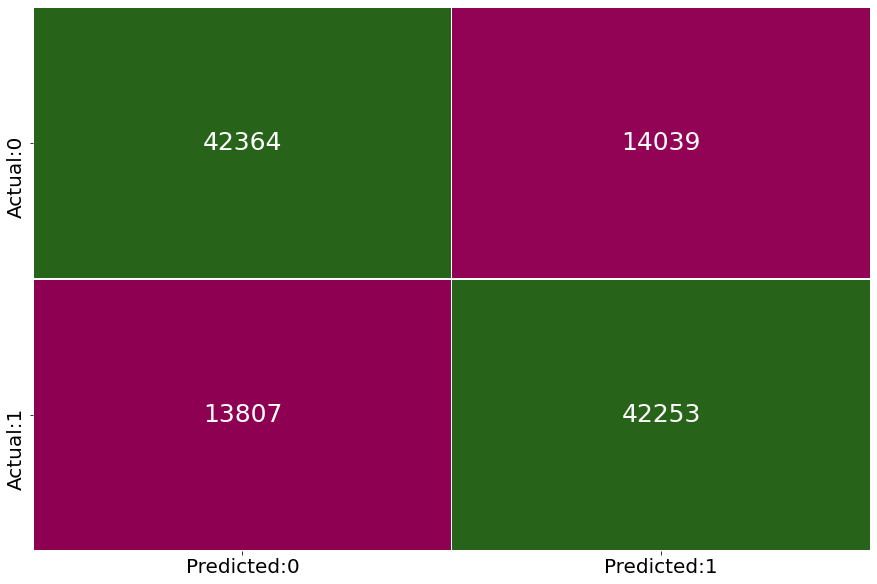

                       Model  Precision  Sensitivity  Correct_classfication  \
0  Extreme Gradient Boosting  75.060399    75.371031              75.239857   

   Misclassfication  
0         24.760143  
*************************************************************************************


In [85]:
print('Extreme Gradient Boosting :\n')
print(plot_confusion_matrix(xg,'Extreme Gradient Boosting',X_train,X_test, y_train,y_test))
print('*'*85)

### Feature Importance:

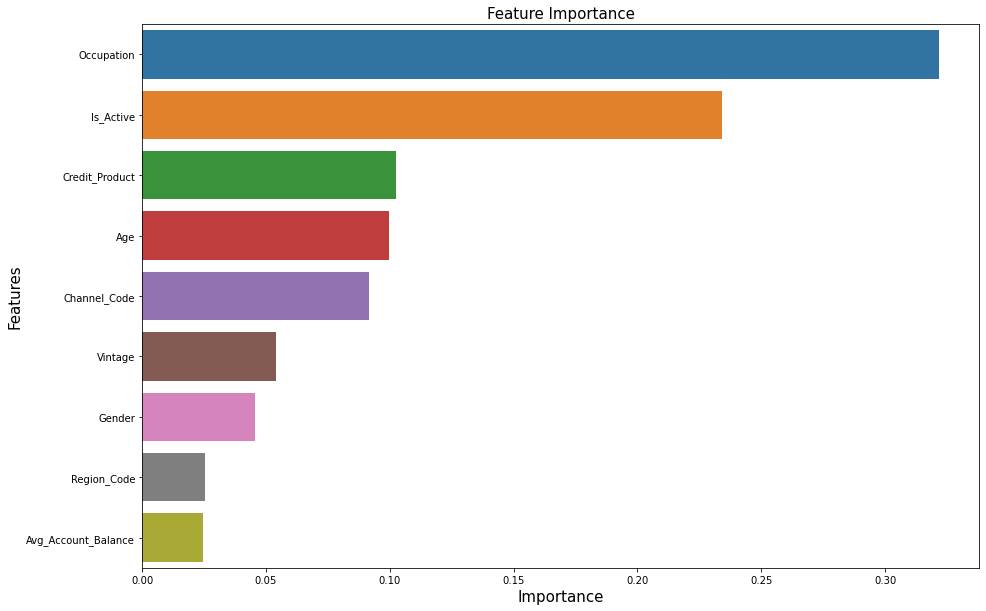

In [86]:
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the gini importance
important_features = pd.DataFrame({'Features': X_train.columns, 
                                   'Importance': xg.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

##### 'Occupation' Feature plays a vital role in predicting the credit card lead.

# Finally generate test results for sample submission

In [87]:
train = df_train.drop(['ID','Is_Lead'],axis=1)
test = df_test.drop(['ID'],axis=1)
ytrain = df_train['Is_Lead']

model = XGBClassifier(subsample=0.4, n_estimators= 30, min_samples_split= 4600, min_child_weight= 0,max_depth= 45, 
                       learning_rate= 0.0001, gamma = 2.0)
model.fit(train, ytrain) # training the model

prediction = model.predict_proba(test) # predicting on the test set
prediction

[20:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[0.5013757 , 0.4986243 ],
       [0.5010567 , 0.49894336],
       [0.5012925 , 0.49870747],
       ...,
       [0.49993223, 0.5000678 ],
       [0.50012016, 0.49987987],
       [0.5012925 , 0.49870747]], dtype=float32)

In [88]:
predict1 = model.predict(test) # predicting on the test set
predict1

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [89]:
#creating dataframe
df5 = pd.DataFrame({"ID":df_test['ID'],"Is_Lead": predict1})

In [104]:
#checking the counts
df5['Is_Lead'].value_counts()/len(df5)*100

0    88.978464
1    11.021536
Name: Is_Lead, dtype: float64

In [92]:
df6 = pd.DataFrame({"ID":df_test['ID']})

In [103]:
prediction_int = prediction[:,1] >= 0.5# if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

# prediction_int = model.predict(test)

df6['Is_Lead'] = list(prediction_int)
df6['Is_Lead'].value_counts()/len(df6)*100

0    88.976565
1    11.023435
Name: Is_Lead, dtype: float64

In [105]:
#save the data with ID and predicted value
df5.to_csv('submission_file.csv',index=False)